# this notebook **heavily** inspect the data prepared by stage2
# TODO: plot resp. param. vs. resp. param. plots across subjects (gird), 80%
# TODO: plot sig beats for interested activity, 70%
# TODO: implement beats inspection

In [2]:
import numpy as np
from numpy_ext import rolling_apply
import numba as nb

import argparse

import os
import math
from math import sin

import pandas as pd
from sklearn.linear_model import LinearRegression


import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and" data are visible in this file
sys.path.append('../../') # add this line so Data "and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from TimeStampReader import *
from stage1_cosmed import *
from PatchParser import *
from preprocessing import *
from ECG_module import *
from PPG_module import *
from segmentation import *
from stage3_inspection import *
from stage4_regression import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
# df = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
#                    'B': {0: 1, 1: 3, 2: 5},
#                    'C': {0: 2, 1: 4, 2: 6}})

# df

In [3]:
# fig, axes = plt.subplots(1,2, figsize=(10, 5), dpi=80)


In [4]:
# pd.melt(df, id_vars=['A'], value_vars=['B', 'C'])


In [5]:
label_range_dict

{'width_QRS': 0.15,
 'ppg': [-100, 100],
 'acc': [-2, 2],
 'ecg': [-5, 5],
 'RR': [5, 60],
 'HR': [40, 220],
 'rer': [0.4, 1.0],
 'vevco2_slope': [20, 50],
 'VT': [0, 500000],
 'SPO2': [5, 100],
 'VE': [0, 5000000],
 'VO2': [0, 5000000],
 'VCO2': [0, 5000000],
 'EE': [0, 100],
 'FiO2': [0, 100],
 'FiCO2': [0, 100],
 'FeO2': [0, 100],
 'FeCO2': [0, 100],
 'GpsAlt': [1, 2000],
 'AmbTemp': [-10, 35],
 'HR_DL': [60, 190]}

In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='101')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage2/', 
                          '--output_folder', '../../data/stage3/',
                          '--subject_id', 'sub107',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage2/', output_folder='../../data/stage3/', subject_id='sub107')


In [4]:
keep_tasks = ['Baseline 0', 'Standing 0', 
              '6MWT 0', 'Recovery 0',
              '6MWT-R 0', 'Recovery 1', 
              'Stair 0', 'Recovery 2', 
              'Walk 0', 'Recovery 3',
              'Run 0', 'Recovery 4']

In [5]:
inputdir = args.input_folder
outputdir = args.output_folder
# subject_id = args.subject_id

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# outputdir_sub = outputdir+subject_id.split('sub')[1]+'/inspection/'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
    

# debug 4Goktug 2/27
## data on dropbox appears to be shuffled?

In [9]:
debug_4Goktug = False

if debug_4Goktug==True:
#     df_sync = pd.read_feather(inputdir+'df_sync_sub110.feather')
#     df_sync = pd.read_csv(inputdir+'df_sync_sub109.csv')
#     df_sync = pd.read_csv(inputdir+'df_sync_sub106.csv')
    df_sync = pd.read_csv(inputdir+'df_sync_sub107.csv')
#     df_sync = pd.read_csv(inputdir+'df_sync_sub110.csv')
#     df_sync = pd.read_csv(inputdir+'df_sync_sub108.csv')

#     t_min = df_sync[df_sync['task']=='6MWT 0']['time'].min()
    t_min = df_sync[df_sync['task']=='6MWT-R 0']['time'].min()
    t_max = df_sync[df_sync['task']=='Run 0']['time'].max()

    fig, ax = plt.subplots(1,1,figsize=(10,2), dpi=80)

    df = df_sync[(df_sync['time']>=t_min) & (df_sync['time']<=t_max)]
    ax.plot(df['time'], df['accelX'])

# get demographic data

In [10]:
filename_subinfo = '../../data/raw/FS Subject Information.xlsx'
df_subinfo = pd.read_excel(filename_subinfo, sheet_name='Subject info') 

i_sub_last = np.where(df_subinfo['Subject_ID'].isnull()==True)[0][0]
df_subinfo = df_subinfo[:i_sub_last]

df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height(cm)', 'Weight(Kg)', 'Gender(0=Male,1=Female)', 'Fitzpatrick', '6MWT distance (m)', '6MWT-R distance (m)']]
df_subinfo = df_subinfo.rename(columns={'Height(cm)': 'Height', 'Weight(Kg)': 'Weight', 'Gender(0=Male,1=Female)': 'Gender'})


from sklearn.preprocessing import OrdinalEncoder

def prepare_OrdinalEncoding(data):
    enc = OrdinalEncoder()
    enc.fit(data[:,None])
    enc.categories_
    return enc.transform(data[:,None])[:,0]




df_subinfo.shape
weight = df_subinfo[df_subinfo['Subject_ID']=='101']['Weight'].values[0]
weight

90.0

In [11]:
stationary_names = ['Baseline 0']
# stationary_names = ['Baseline 0']
for j in range(5):
    stationary_names.append('Recovery ' + str(j))
# stationary_names.append( '6MWT 0' )
# stationary_names.append( '6MWT-R 0' )
# stationary_names.append( 'Stair 0' )
# stationary_names.append( 'Walk 0' )
# stationary_names.append( 'Run 0' )

stationary_names

['Baseline 0',
 'Recovery 0',
 'Recovery 1',
 'Recovery 2',
 'Recovery 3',
 'Recovery 4']

In [12]:
# RQ_cal = np.asarray([
#     [0.70, 4.60],
#     [0.71, 4.62],
#     [0.72, 4.63],
#     [0.73, 4.64],
#     [0.74, 4.66],
#     [0.75, 4.68],
#     [0.76, 4.69],
#     [0.77, 4.71],
#     [0.78, 4.72],
#     [0.79, 4.74],
#     [0.80, 4.75],
#     [0.81, 4.77],
#     [0.82, 4.78],
#     [0.83, 4.80],
#     [0.84, 4.81],
#     [0.85, 4.83],
#     [0.86, 4.84],
#     [0.87, 4.86],
#     [0.88, 4.87],
#     [0.89, 4.89],
#     [0.90, 4.90],
#     [0.91, 4.92],
#     [0.92, 4.93],
#     [0.93, 4.95],
#     [0.94, 4.96],
#     [0.95, 4.98],
#     [0.96, 4.99],
#     [0.97, 5.01],
#     [0.98, 5.02],
#     [0.99, 5.04],
#     [1.00, 5.05],
# ])
RQ_lookup = np.asarray([
[0.70,		4.60,		100.0,		0.0],
[0.71,		4.62,		96.7,		3.3],
[0.72,		4.63,		93.3,		6.7],
[0.73,		4.64,		90.0,		10.0],
[0.74,		4.66,		86.7,		13.3],
[0.75,		4.68,		83.3,		16.7],
[0.76,		4.69,		80.0,		20.0],
[0.77,		4.71,		76.7,		23.3],
[0.78,		4.72,		73.3,		26.7],
[0.79,		4.74,		70.0,		30.0],
[0.80,		4.75,		66.7,		33.3],
[0.81,		4.77,		63.3,		36.7],
[0.82,		4.78,		60.0,		40.0],
[0.83,		4.80,		56.7,		43.3],
[0.84,		4.81,		53.3,		46.7],
[0.85,		4.83,		50.0,		50.0],
[0.86,		4.84,		46.7,		53.3],
[0.87,		4.86,		43.3,		56.7],
[0.88,		4.87,		40.0,		60.0],
[0.89,		4.89,		36.7,		63.3],
[0.90,		4.90,		33.3,		66.7],
[0.91,		4.92,		30.0,		70.0],
[0.92,		4.93,		26.7,		73.3],
[0.93,		4.95,		23.3,		76.7],
[0.94,		4.96,		20.0,		80.0],
[0.95,		4.98,		16.7,		83.3],
[0.96,		4.99,		13.3,		86.7],
[0.97,		5.01,		10.0,		90.0],
[0.98,		5.02,		6.7,		93.3],
[0.99,		5.04,		3.3,		96.7],
[1.00,		5.05,		0.0,		100.0],])


# get f_RQinterp first
f_CalEqinterp = interp1d(RQ_lookup[:,0], RQ_lookup[:,1])
f_FatPercinterp = interp1d(RQ_lookup[:,0], RQ_lookup[:,2])
f_CarbPercinterp = interp1d(RQ_lookup[:,0], RQ_lookup[:,3])


In [13]:
scale_label_names = ['EErq_cosmed', 'EE_cosmed', 'VE_cosmed', 'VT_cosmed', 'VO2_cosmed', 'VCO2_cosmed', 'OUES_cosmed']

# 'HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed',

In [14]:
no_scaling = False

df_sync = pd.DataFrame()
# for i in range(21):

for i in range(300):
    subject_id = 'sub'+str(i)

    # TODO: "transplant" the ECG of their other patches to the chest
    if (subject_id =='sub212') or (subject_id =='sub114'):
        continue
    
    inputdir_sub = inputdir+subject_id+'/'
    if subject_id not in os.listdir(inputdir):
        continue
   
    print('subject_id is ', subject_id)

    for syn_file in os.listdir(inputdir_sub):
        if '.feather'  in syn_file:
            df_sub = pd.read_feather(inputdir_sub+syn_file)
#             df_sub = filter_DFcolumns(df_sub.copy(), Fs)


    # do 250->2.5 Hz downsampling instead
#     df_sub = df_sub[df_sub['Sampled_cosmed']==1]
#     sys.exit()


    # get EErq_cosmed
    # 1 convert R to Rnormed
    df_sub['Rnormed_cosmed'] = df_sub['K5_R_cosmed'].copy()
    df_sub.loc[df_sub['Rnormed_cosmed'] > 1, 'Rnormed_cosmed'] = 1
    df_sub.loc[df_sub['Rnormed_cosmed'] < 0.7, 'Rnormed_cosmed'] = 0.7

    # 2. get RQ_calories, 
    df_sub['RQ_calories'] = f_CalEqinterp(df_sub['Rnormed_cosmed'].values)/1000
    df_sub['FatPerc'] = f_FatPercinterp(df_sub['Rnormed_cosmed'].values) # %
    df_sub['CarbPerc'] = f_CarbPercinterp(df_sub['Rnormed_cosmed'].values) # %

    # 3. get EErq_cosmed [kcal/min]
    df_sub['EErq_cosmed'] = df_sub['RQ_calories'] * df_sub['VO2_cosmed']

    weight = df_subinfo[df_subinfo['Subject_ID']==subject_id.split('sub')[1]]['Weight'].values[0]

    for label_name in scale_label_names:
        df_sub[label_name] = df_sub[label_name] / weight
    
    
    # get raw task names except for Transition
    task_unique = df_sub['task'].unique()
    task_unique = task_unique[task_unique!='Transition']

#     sys.exit()
#     print(task_unique)
    
    for task_name in keep_tasks:
        if 'Recovery' in task_name:
            previous_task = task_unique[np.where(task_unique==task_name)[0]-1][0]
            task_name_new = previous_task.split(' ')[0] + ' Recovery'
        else:
            task_name_new = task_name.split(' ')[0]
            
        
        df_task = df_sub[df_sub['task']==task_name].copy()
        
#         sys.exit()
        
        if 'Recovery' in task_name:
            t_exercise_end = df_sub[df_sub['task']==previous_task]['time'].max()
        else:
            t_exercise_end = df_task['time'].min()
            
        df_task['time'] = df_task['time'] - t_exercise_end
        
#         df_task = df_task['time']*

#         sys.exit()

        # down sample while keep cosmed variables aligned
        df_task = df_task[(df_task['time'].values%2)==0]

        
        df_task['task'] = task_name_new
        
        df_task['subject_id'] = int(subject_id.split('sub')[1])

        df_sync = df_sync.append( df_task, ignore_index=True )



subject_id is  sub101
subject_id is  sub102
subject_id is  sub103
subject_id is  sub104
subject_id is  sub105
subject_id is  sub106
subject_id is  sub107
subject_id is  sub108
subject_id is  sub109
subject_id is  sub110
subject_id is  sub111
subject_id is  sub113
subject_id is  sub115
subject_id is  sub116
subject_id is  sub117
subject_id is  sub118
subject_id is  sub119
subject_id is  sub120
subject_id is  sub121


In [15]:
# df_sync

In [16]:
df_sync['O2pulse_cosmed'] = df_sync['VO2_cosmed'] / df_sync['HR_cosmed']

In [17]:
task_color_dict = {
    'Baseline': '#4682B4', #'SteelBlue',
    'Standing': '#1A4876', #''MidnightBlue',
    '6MWT':  '#E4682A', # 'Deep Carrot Orange',
    '6MWT Recovery': '#AFE1AF', #Celadon
    '6MWT-R': '#800000', # 'Maroon',
    '6MWT-R Recovery': '#5F9EA0', #Cadet Blue
    'Stair': '#8A3324', # 'burntumber',
    'Stair Recovery': '#228B22', #Forest Green
    'Walk': '#b22222', # 'Firebrick',
    'Walk Recovery': '#008000',  #Green
    'Run': '#ffd8b1', # 'Coral',
    'Run Recovery': '#478778',	#Lincoln Green
}


In [18]:
df_sync['OUES_cosmed_inversed'] = 1/df_sync['OUES_cosmed']

# df_OUES_inversed = df_sync[(df_sync['OUES_cosmed_inversed']>0) & (df_sync['OUES_cosmed_inversed']<100)][['OUES_cosmed_inversed', 'task', 'subject_id']]
# df_OUES_inversed = df_sync[['OUES_cosmed_inversed','OUES_cosmed', 'task', 'subject_id']]
df_OUES = df_sync.copy()
df_OUES = df_OUES[['OUES_cosmed_inversed','OUES_cosmed', 'task', 'subject_id', 'Sampled_cosmed']]
# df_OUES = df_OUES[df_OUES['Sampled_cosmed']==1]

df_OUES['OUES_cosmed_inversed'] = 1/df_OUES['OUES_cosmed']

# plt.plot(df_sync[(df_sync['OUES_cosmed_inversed']>0) & (df_sync['OUES_cosmed_inversed']<100)]['OUES_cosmed_inversed'])

In [19]:
# df_sync['Sampled_cosmed']

In [20]:
# df_sync['OUES_cosmed'] 

Text(0, 0.5, 'VE/VO2')

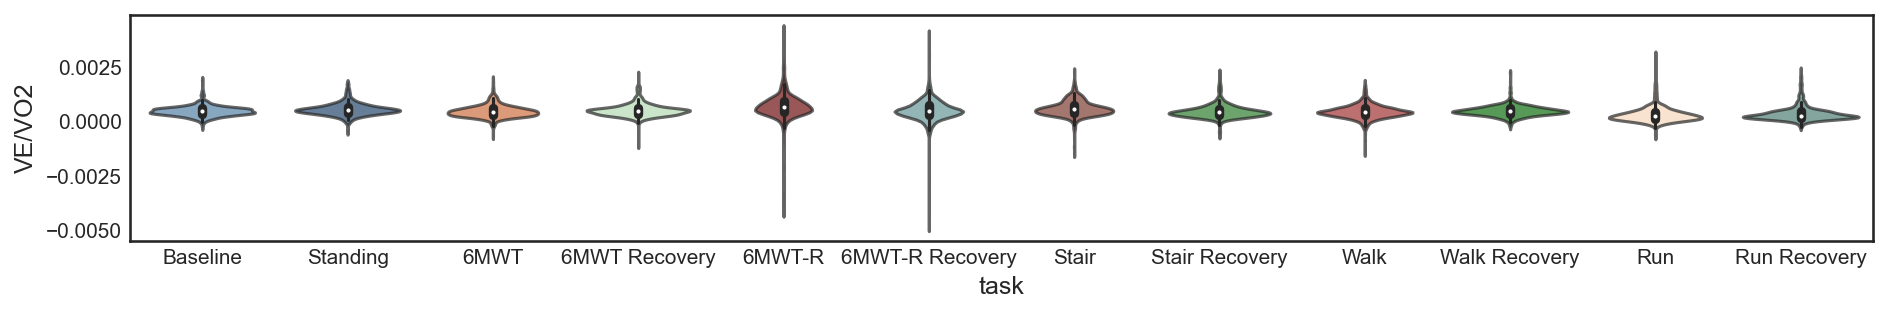

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,2), dpi=150)

sns.violinplot(x="task", y="OUES_cosmed", data=df_OUES, ax=ax, palette=task_color_dict)
for violin in ax.collections[::2]:
    violin.set_alpha(0.7)
ax.set_xlabel("task", fontsize = 12)
ax.set_ylabel("VE/VO2", fontsize = 12)

Text(0, 0.5, 'VE/VO2')

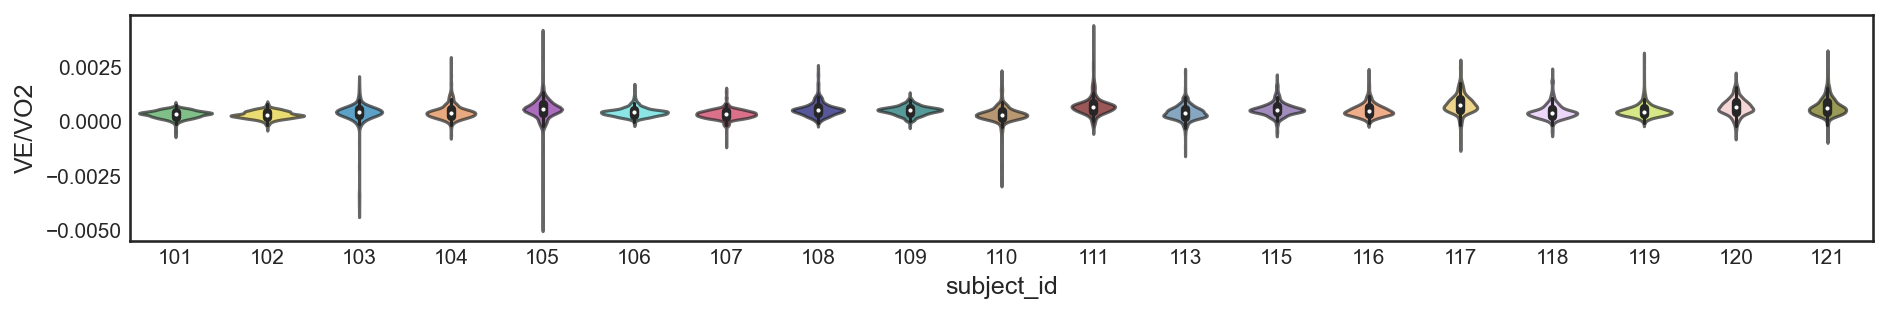

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,2), dpi=150)

sns.violinplot(x="subject_id", y="OUES_cosmed", data=df_OUES, ax=ax, palette=subject_palette)
for violin in ax.collections[::2]:
    violin.set_alpha(0.7)
ax.set_xlabel("subject_id", fontsize = 12)
ax.set_ylabel("VE/VO2", fontsize = 12)

In [23]:
df_OUES = df_OUES[(df_OUES['task']!='Run') & (df_OUES['task']!='Run Recovery')]

Text(0, 0.5, 'VE/VO2')

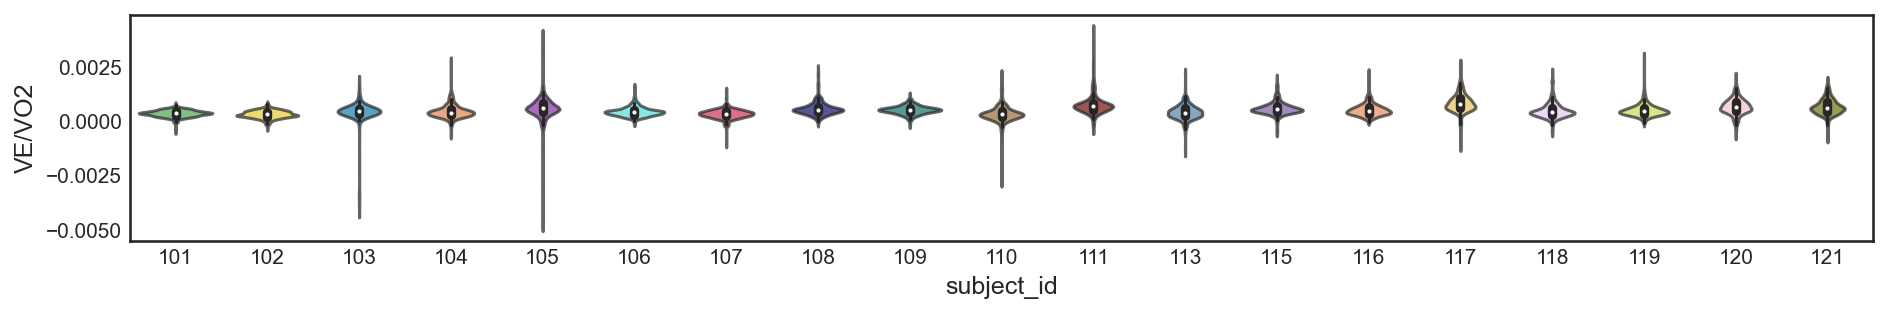

In [24]:
fig, ax = plt.subplots(1,1,figsize=(15,2), dpi=150)

sns.violinplot(x="subject_id", y="OUES_cosmed", data=df_OUES, ax=ax, palette=subject_palette)
for violin in ax.collections[::2]:
    violin.set_alpha(0.7)
ax.set_xlabel("subject_id", fontsize = 12)
ax.set_ylabel("VE/VO2", fontsize = 12)

In [25]:
def plot_agg_resp(df_plot):
    
    x_min, x_max = df_plot['time'].min(), df_plot['time'].max()

    
    fig, axes = plt.subplots(11,1,figsize=((x_max-x_min)/180*3,10),  gridspec_kw = {'wspace':0, 'hspace':0}, dpi=100)

    fontsize = 12
    ax = axes[0]
    sns.lineplot(data=df_plot, x="time", y="EErq_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('EE\n[kcal/kg/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))


    ax = axes[1]
    sns.lineplot(data=df_plot, x="time", y="VE_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('VE\n[ml/kg/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))

    ax = axes[2]
    sns.lineplot(data=df_plot, x="time", y="RR_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('RR\n[breath/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))

    ax = axes[3]
    sns.lineplot(data=df_plot, x="time", y="VT_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('VT\n[ml/kg]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))


    ax = axes[4]
    sns.lineplot(data=df_plot, x="time", y="HR_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('HR\n[beat/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))

    ax = axes[5]
    sns.lineplot(data=df_plot, x="time", y="O2pulse_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('O2 pulse\n[ml/kg/beat]')

    ax = axes[6]
    sns.lineplot(data=df_plot, x="time", y="FatPerc", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('FatPerc\n[%]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))


    ax = axes[7]
    sns.lineplot(data=df_plot, x="time", y="CarbPerc", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('CarbPerc\n[%]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))


    ax = axes[8]
    sns.lineplot(data=df_plot, x="time", y="VO2_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('VO2\n[ml/kg/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))

    ax = axes[9]
    sns.lineplot(data=df_plot, x="time", y="VCO2_cosmed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('VCO2\n[ml/kg/min]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))


    ax = axes[10]
    sns.lineplot(data=df_plot, x="time", y="OUES_cosmed_inversed", hue='task', ax=ax, palette=task_color_dict)
    ax.set_ylabel('VE/VO2\n[a.u.]')
#     ax_no_top_right(ax)
#     ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))



    
    ax.set_xlabel('time (s)')
    for ax in axes:
        ax.set_xlim(x_min, x_max)
        ax_no_top_right(ax)
        ax.legend(frameon=True, fontsize=fontsize, bbox_to_anchor=(1.01, 1))

    # plt.show()

In [26]:
# plt.plot(df_sync['OUES_cosmed_inversed'].values)

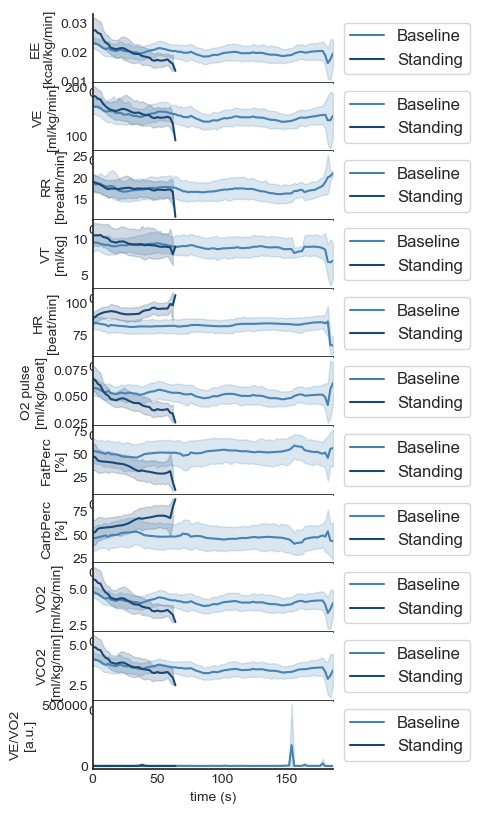

In [27]:
df_plot = df_sync[(df_sync['task']=='Baseline') | (df_sync['task']=='Standing')].copy()
# df_plot = df_plot[df_plot['Sampled_cosmed']==1]

# df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) & (df_plot['OUES_cosmed_inversed']<100)]
df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) ]

plot_agg_resp(df_plot)

In [28]:
# df_plot = df_sync[(df_sync['task']=='6MWT') | (df_sync['task']=='6MWT-R')].copy()
# df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) & (df_plot['OUES_cosmed_inversed']<100)]

# plot_agg_resp(df_plot)

In [29]:
# df_plot = df_sync[(df_sync['task']=='6MWT Recovery') | (df_sync['task']=='6MWT-R Recovery')].copy()
# df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) & (df_plot['OUES_cosmed_inversed']<100)]

# plot_agg_resp(df_plot)

In [30]:
# df_plot = df_sync[(df_sync['task']=='6MWT') | (df_sync['task']=='6MWT Recovery')].copy()
# df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) & (df_plot['OUES_cosmed_inversed']<100)]

# plot_agg_resp(df_plot)

In [31]:
# df_plot = df_sync[(df_sync['task']=='Run') | (df_sync['task']=='Run Recovery')].copy()
# df_plot = df_plot[(df_plot['OUES_cosmed_inversed']>0) & (df_plot['OUES_cosmed_inversed']<100)]

# plot_agg_resp(df_plot)

In [32]:
df_performance = pd.DataFrame()
task_name = 'Run Recovery'

df_recovery_analysis =  df_sync[(df_sync['task']==task_name)].copy()

for subject_id in df_recovery_analysis['subject_id']:

    df_sub = df_recovery_analysis[df_recovery_analysis['subject_id']==subject_id]
#     EE_exercise =     
    df_recovery = df_recovery_analysis[df_recovery_analysis['task']==task_name]
    
#     df_recovery = df_recovery[df_recovery['Sampled_cosmed']==1]



#     x = df_recovery['time'].values
#     y = df_recovery['EE_cosmed'].values

    model = LinearRegression()

    
    feature_train = df_recovery[df_recovery['subject_id']!=subject_id]['time'].values[:,None]
    label_train = df_recovery[df_recovery['subject_id']!=subject_id]['EE_cosmed'].values

    
    feature_val = df_recovery[df_recovery['subject_id']==subject_id]['time'].values[:,None]
    label_val = df_recovery[df_recovery['subject_id']==subject_id]['EE_cosmed'].values


    model = model.fit(feature_train, np.log(label_train))
    label_est_train = np.exp(model.predict(feature_train))
    label_est_val = np.exp(model.predict(feature_val))

    weight = df_subinfo[df_subinfo['Subject_ID']==str(subject_id)]['Weight'].values[0]

    df_performance = df_performance.append(pd.DataFrame({
       'label_est': label_est_val*weight, 
       'label': label_val*weight,
       'CV': subject_id, 
       'task': 'EE_cosmed',
    }))

In [33]:
mae_val, _ = get_MAE( df_performance['label'].values,  df_performance['label_est'].values)
Rsquared_val = get_CoeffDeterm( df_performance['label'].values,  df_performance['label_est'].values)
PCC_val = get_PCC( df_performance['label'].values,  df_performance['label_est'].values)
mae_val , Rsquared_val, PCC_val

(1.0799077606904912, 0.778382544432515, 0.8892231497380814)

In [36]:
# task_name

In [37]:
# plot_regression(df_performance, None, task_name, fig_name=None, show_plot=True, outputdir=None, log_wandb=False)


In [38]:
# EE_exercise_plateau = df_exercise['EE_cosmed'].mean()

In [39]:
df_recovery = df_sync[df_sync['task']=='Run Recovery']


x = df_recovery['time'].values[:,None]
y = np.log(df_recovery['EE_cosmed'].values)

In [40]:
model = LinearRegression()
model = model.fit(x, y)


In [41]:
y_est =  np.exp(model.predict(x))

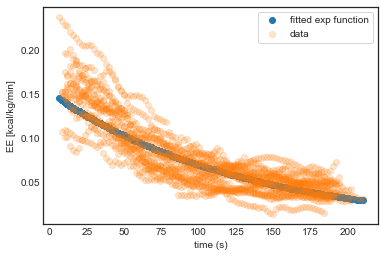

In [42]:
plt.scatter(x, y_est, label='fitted exp function')
plt.scatter(x, np.exp(y), alpha=0.2, label='data')
plt.xlabel('time (s)')
plt.ylabel('EE [kcal/kg/min]')
plt.legend(frameon=True)

# TODO: plot these in a loop

In [43]:
df_sync['subject_id'].unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115,
       116, 117, 118, 119, 120, 121])

In [44]:
# df_sync

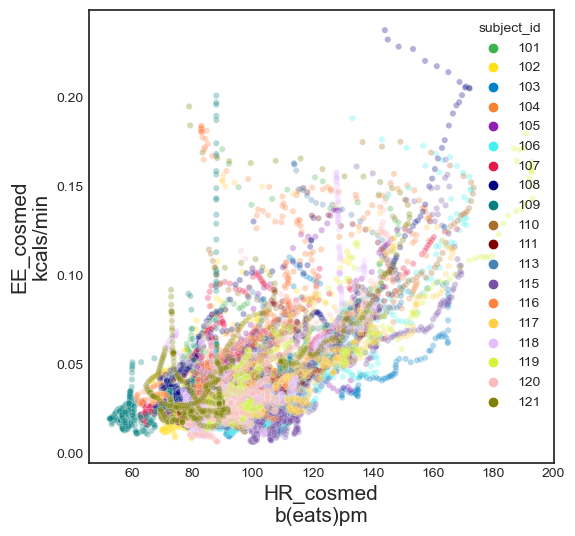

In [45]:

# df = df_sync[df_sync['Sampled_cosmed']==1].copy()
# df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
# df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
#         (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]
df = df_sync[(df_sync['task']=='Baseline') | (df_sync['task']=='Standing') | (df_sync['task']=='6MWT Recovery') | (df_sync['task']=='6MWT-R Recovery')| 
        (df_sync['task']=='Stair Recovery') | (df_sync['task']=='Walk Recovery') | (df_sync['task']=='Run Recovery')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="HR_cosmed", y="EE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)

ax.set_xlabel('HR_cosmed\n'+unit_dict['HR'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['EE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/HR_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


# TBD (may not need this)

In [46]:
import seaborn as sns

df = df_cosmed_all[df_cosmed_all['Sampled_cosmed']==1].copy()
df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
        (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VE_cosmed", y="EE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)

ax.set_xlabel('VE_cosmed\n'+unit_dict['VE'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['EE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VE_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


NameError: name 'df_cosmed_all' is not defined

In [ ]:
import seaborn as sns

df = df_cosmed_all[df_cosmed_all['Sampled_cosmed']==1].copy()
df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
        (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VO2_cosmed", y="EE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)

ax.set_xlabel('VO2_cosmed\n'+unit_dict['VO2'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['EE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


In [ ]:
import seaborn as sns

df = df_cosmed_all[df_cosmed_all['Sampled_cosmed']==1].copy()
df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
        (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)

ax.set_xlabel('VO2_cosmed\n'+unit_dict['VO2'], fontsize=fontsize)
ax.set_ylabel('VE_cosmed\n'+unit_dict['VE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_VE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


In [ ]:
import seaborn as sns

df = df_cosmed_all[df_cosmed_all['Sampled_cosmed']==1].copy()
df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
        (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="RR_cosmed", y="EE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)
ax.set_xlabel('RR_cosmed\n'+unit_dict['RR'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['EE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/RR_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


In [ ]:
import seaborn as sns

df = df_cosmed_all[df_cosmed_all['Sampled_cosmed']==1].copy()
df = df[df['task']!='Transition']
# df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
#         (df['task']=='Run 0') | (df['task']=='Recovery 4')]
df = df[(df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Recovery 3')| 
        (df['task']=='Recovery 2') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="SPO2_cosmed", y="EE_cosmed", hue="subject_id", ax=ax, palette=subject_palette, alpha=0.3, s=20)
ax.set_xlabel('SPO2_cosmed\n'+unit_dict['RR'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['EE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/SPO2_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


In [47]:
sns.lineplot(data=df_EE_6MWT, x=df_EE_6MWT.index, y="EE_cosmed")
plt.show()

NameError: name 'df_EE_6MWT' is not defined

# get sync data

In [48]:
# inputdir_sub = inputdir+subject_id+'/'
# for syn_file in os.listdir(inputdir_sub):
#     if 'feather' not in syn_file:
#         continue
#     df_sync = pd.read_feather(inputdir_sub+syn_file)

In [ ]:
# df_sync[df_sync['task'] == 'Baseline 0']

In [ ]:
Fs = FS_RESAMPLE

In [ ]:
unit_dict

In [ ]:
df_sync['task'].unique()

# get OUES, move to stage2
# TODO: write documentation

In [49]:
# lighting fast! 
@nb.njit(fastmath=True)
def get_slope(X, Y):
    downsample_factor = int(FS_RESAMPLE/5) # respiratory params should be slower than 1Hz
#     downsample_factor = 1 # respiratory params should be slower than 1Hz

    X = X[::downsample_factor]
    Y = Y[::downsample_factor]
    m_x=np.mean(X)
    m_y=np.mean(Y)
    return np.sum((X-m_x)*(Y-m_y))/np.sum((X-m_x)**2)

def roll_dataframe(df_raw, window, col1, col2, col_new, compute_method):
    df = df_raw.copy()
    df[col_new] = np.nan


    df_start = df[:window//2].iloc[::-1].copy()
    df_end = df[df.shape[0]-window//2:].iloc[::-1].copy()

    df_padded = pd.concat([df_start, df, df_end])
    

    df_padded = df_padded.reset_index(drop=True)
    v_arr = rolling_apply(compute_method, window, df_padded[col1].values, df_padded[col2].values,)

    df_padded.loc[(window-1)//2:df_padded.shape[0]-(window//2)-1, col_new] =  v_arr[window-1:]
    
    df_rolled = df_padded[window//2:df_padded.shape[0]-window//2]
    
    return df_rolled

In [50]:
%%time
window = int(30*FS_RESAMPLE)
# aaa = roll_dataframe(df_sync[:500*FS_RESAMPLE], window, 'VE_cosmed', 'VO2_cosmed', 'OUES', get_slope)
df_sync = roll_dataframe(df_sync, window, 'VE_cosmed', 'VO2_cosmed', 'OUES_cosmed', get_slope)


CPU times: user 759 ms, sys: 13.1 ms, total: 772 ms
Wall time: 788 ms


In [51]:
try_kneebrace = False

if try_kneebrace: 
    df_knee = pd.read_feather('../../data/stage1/'+subject_id+'/knee/df_knee.feather')

    # Estimation_EE/data/stage1/sub106/knee/df_knee.feather
    t_arr = df_sync[df_sync['task']=='6MWT-R 0']['time'].values

    t_start = t_arr[0] - 120
    t_end = t_arr[-1] + 120

    df_sync_copy = df_sync[(df_sync['time']>=t_start) & (df_sync['time']<=t_end)].copy()

    df_sync_copy = df_sync_copy[:df_knee.shape[0]].reset_index(drop=True)

    df_sync_copy['time'] = df_sync_copy['time'] - df_sync_copy['time'].min()

    df_sync_copy = df_sync_copy.merge(df_knee, on='time')
    # df_sync_copy = df_knee.merge(df_sync_copy, on='time')

    plt_scale = 1.5
    add_sigs = ['OUES_cosmed', 'acc0_x', 'acc0_y', 'acc0_z', 'acc1_x', 'acc1_y',
           'acc1_z', 'gyr0_x', 'gyr0_y', 'gyr0_z', 'gyr1_x', 'gyr1_y', 'gyr1_z',
           'Resistance5', 'Resistance100']
    df_plot = df_sync_copy[:].copy()
    print(df_plot['time'].max() - df_plot['time'].min() )

    plot_all_sync(df_plot, subject_id, plotted_sigs = add_sigs + PLOTTED_SIGS, plt_scale=plt_scale, 
                  fig_name='df_sub_csv [1st 6MWT]', outputdir=outputdir_sub, show_plot=False)
    #     plot_all_sync(df, subject_id, plt_scale=plt_scale, fig_name='df_sub_csv [1st 6MWT till Recovery of Run]', outputdir=outputdir_sub, show_plot=True)


# data 4 Goktug

In [52]:
export_4Goktug = False

if export_4Goktug:
    
    task_start = []
    previous_task = 'None'
    for task in df_sync['task'].unique():
        if '6MWT' in task:
            task_start.append(task)
        if 'Run 0' == previous_task:
            task_end = task
        previous_task = task

    task_start = task_start[0]
    print(task_start, task_end)

    t_start = df_sync[df_sync['task']==task_start]['time'].min()-100
    t_end = df_sync[df_sync['task']==task_end]['time'].max()

#     task_name = '6MWT 0'
#     task_name = 'LR 0'

#     df = df_sync[df_sync['task']==task_name].copy()
#     t_start = df['time'].min() - 5
#     t_end = df['time'].min() + 20
#     t_end = df['time'].max() + 20
    df = df_sync[(df_sync['time'] >= t_start) & (df_sync['time'] <= t_end)].copy()

    df['time'] = df['time'].values - df['time'].min()
#     df.loc[:,'time'] = df['time'].values - df['time'].min()

    df = df.reset_index()
    
    plt_scale = 1.2

    plot_all_sync(df, subject_id, plotted_sigs = PLOTTED_SIGS + ['OUES'], plt_scale=plt_scale, 
                  fig_name='df_sub_csv [1st 6MWT till Recovery of Run]', outputdir=outputdir_sub, show_plot=True)
#     plot_all_sync(df, subject_id, plt_scale=plt_scale, fig_name='df_sub_csv [1st 6MWT till Recovery of Run]', outputdir=outputdir_sub, show_plot=True)


    df.to_csv(outputdir_sub+'df_4sub.csv')

# get a small segment of the sync signal

In [53]:
# get a copy of data in this range
# df = get_filt_df(df_sync, Fs).copy()
df = df_sync.copy()
# df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

# downsample it to make plotting quicker
downsample_factor = 5
df = df[df.index%downsample_factor==0]

# plot the signals
plt_scale = 20
plot_all_sync(df, subject_id, plt_scale=plt_scale, plotted_sigs=PLOTTED_SIGS+['OUES_cosmed'], outputdir=outputdir_sub, show_plot=True)


NameError: name 'outputdir_sub' is not defined

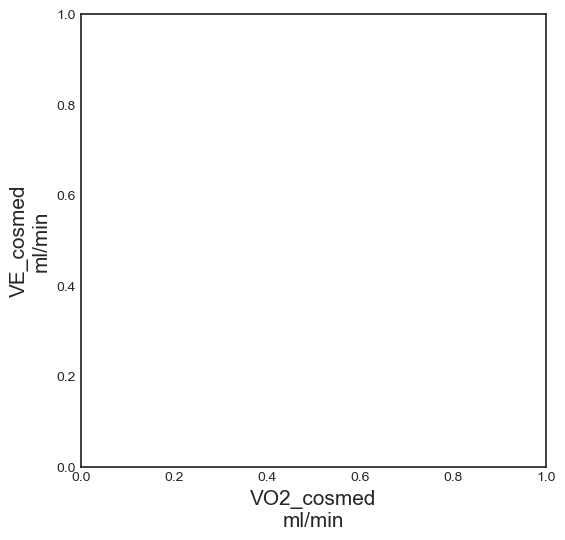

In [54]:
import seaborn as sns

df = df_sync[df_sync['Sampled_cosmed']==1].copy()
df['VO2_cosmed'] = df['VO2_cosmed']
df = df[df['task']!='Transition']
df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
        (df['task']=='Run 0') | (df['task']=='Recovery 4') | (df['task']=='Exhaustion 0') | (df['task']=='Exhaustion 1') | (df['task']=='Recovery 5')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)

ax.set_xlabel('VO2_cosmed\n'+unit_dict['VO2'], fontsize=fontsize)
ax.set_ylabel('VE_cosmed\n'+unit_dict['VE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_VE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


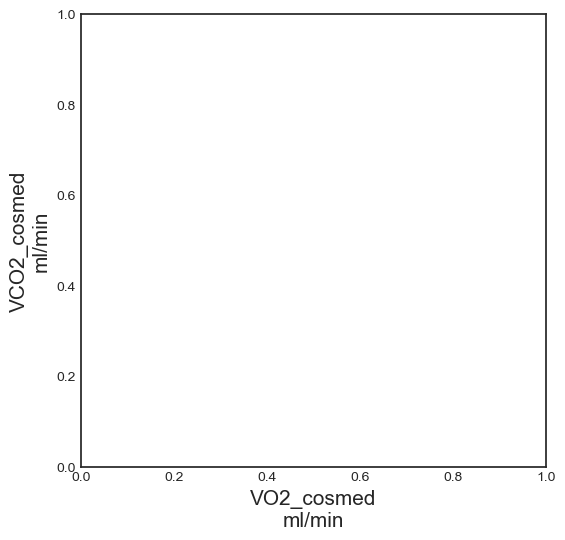

In [55]:
import seaborn as sns

df = df_sync[df_sync['Sampled_cosmed']==1].copy()
df['VO2_cosmed'] = df['VO2_cosmed']
df = df[df['task']!='Transition']
df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
        (df['task']=='Run 0') | (df['task']=='Recovery 4') | (df['task']=='Exhaustion 0') | (df['task']=='Exhaustion 1') | (df['task']=='Recovery 5')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VO2_cosmed", y="VCO2_cosmed", hue="task", ax=ax)

ax.set_xlabel('VO2_cosmed\n'+unit_dict['VO2'], fontsize=fontsize)
ax.set_ylabel('VCO2_cosmed\n'+unit_dict['VE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_VCO2'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


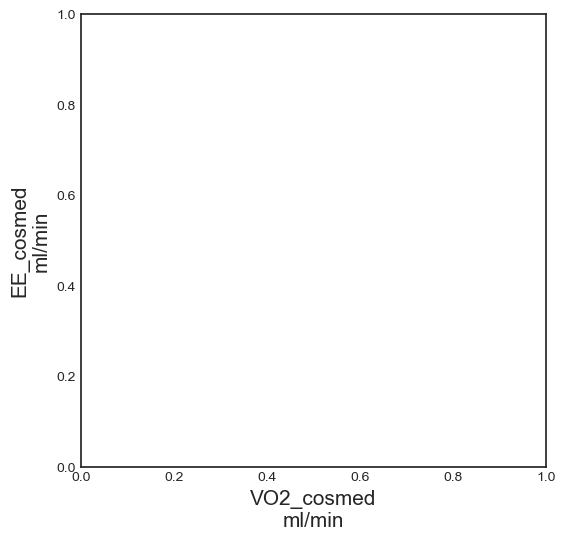

In [56]:
import seaborn as sns

df = df_sync[df_sync['Sampled_cosmed']==1].copy()
df['VO2_cosmed'] = df['VO2_cosmed']
df = df[df['task']!='Transition']
df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| 
        (df['task']=='Run 0') | (df['task']=='Recovery 4') | (df['task']=='Exhaustion 0') | (df['task']=='Exhaustion 1') | (df['task']=='Recovery 5')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)
fontsize = 15

# sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)
sns.scatterplot(data=df, x="VO2_cosmed", y="EE_cosmed", hue="task", ax=ax)

ax.set_xlabel('VO2_cosmed\n'+unit_dict['VO2'], fontsize=fontsize)
ax.set_ylabel('EE_cosmed\n'+unit_dict['VE'], fontsize=fontsize)
#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_EE'

fig.savefig(outputdir + fig_name+'.png', transparent=False)


# 3. getting patch ECG beats and i_R_peaks
## make a dictionary to store the beats and plot them

In [57]:
# plot_all_sync(df, subject_id, fig_name='all', outputdir=outputdir+task_name+'/', show_plot=False)


# detect R peaks

In [58]:
df_sync['task'].unique()

array(['Baseline', 'Standing', '6MWT', '6MWT Recovery', '6MWT-R',
       '6MWT-R Recovery', 'Stair', 'Stair Recovery', 'Walk',
       'Walk Recovery', 'Run', 'Run Recovery'], dtype=object)

In [59]:
FS_tasks

['Baseline 0',
 'Standing 0',
 'Proning 0',
 'LL 0',
 'LR 0',
 'Cough 0',
 'SpeakCasual 0',
 'SpeakScripted 0',
 '6MWT 0',
 'Recovery 0',
 '6MWT-R 0',
 'Recovery 1',
 'Stair 0',
 'Recovery 2',
 'Cough 1',
 'SpeakCasual 1',
 'SpeakScripted 1',
 'Walk 0',
 'Recovery 3',
 'Run 0',
 'Recovery 4',
 'Exhaustion 0',
 'Recovery 5',
 'Exhaustion 1',
 'Recovery 6']

In [ ]:
sys.exit()

# TBD (moved to inspection_beats.ipynb)
# plot beats (acc, ecg, ppg)

In [1]:
# del df_sync

df_sync = pd.DataFrame()

for i in range(300):
    subject_id = 'sub'+str(i)

    # TODO: "transplant" the ECG of their other patches to the chest
    if (subject_id =='sub212') or (subject_id =='sub114'):
        continue
    
    inputdir_sub = inputdir+subject_id+'/'
    if subject_id not in os.listdir(inputdir):
        continue
   
    print('subject_id is ', subject_id)

    for syn_file in os.listdir(inputdir_sub):
        if '.feather'  not in syn_file:
            continue
            
        df_sub = pd.read_feather(inputdir_sub+syn_file)
#             df_sub = filter_DFcolumns(df_sub.copy(), Fs)
        df_sub['subject_id'] = int(subject_id.split('sub')[1])

#             df_sync = df_sync.append(df_sub[['time', 'subject_id', 'task', 'ECG', 'accelX', 'accelY','accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2','ppg_ir_2']])
    
    
    
        # get raw task names except for Transition
        task_unique = df_sub['task'].unique()
        
        task_unique = task_unique[task_unique!='Transition']

#         sys.exit()
    #     print(task_unique)
    

        for task_name in keep_tasks:
            if 'Recovery' in task_name:
                previous_task = task_unique[np.where(task_unique==task_name)[0]-1][0]
                task_name_new = previous_task.split(' ')[0] + ' Recovery'
            else:
                task_name_new = task_name.split(' ')[0]


            df_task = df_sub[df_sub['task']==task_name].copy()

            df_task['task'] = task_name_new
        
        
        
        
        
    

#         for task_name in keep_tasks:
#             if 'Recovery' in task_name:
#                 previous_task = task_unique[np.where(task_unique==task_name)[0]-1][0]
#                 task_name_new = previous_task.split(' ')[0] + ' Recovery'
#             else:
#                 task_name_new = task_name.split(' ')[0]

                
#         sys.exit()
#         df_sub['task'] = task_name_new
                
            df_sync = df_sync.append(df_task)


NameError: name 'pd' is not defined

In [10]:
# # df_sync['task'].uniquekeep_tasks
df_sync['subject_id'].unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115,
       116, 117, 118, 119, 120, 121])

In [12]:
beats_id = [1, 10, 2, 6, 11, 3, 7, 4, 8, 12, 0]
use_ensemble = True


# for task_name in FS_tasks:
# for task_name in ['Baseline', 'Standing', '6MWT', '6MWT Recovery', '6MWT-R', '6MWT-R Recovery', 'Stair', 'Stair Recovery', 'Walk', 'Walk Recovery', 'Run', 'Run Recovery']:


for subject_id in df_sync['subject_id'].unique():
    
    if subject_id<117:
        continue
    df_sub = df_sync[df_sync['subject_id']==subject_id]
    
    

    #     t_start = df_sync[df_sync['task']==task_name]['time'].min()


#     for task_name in ['Baseline 0', 'Standing 0', 'Recovery 0', 'Recovery 1', 'Recovery 2', 'Recovery 3', 'Recovery 4']:
    for task_name in ['Baseline', 'Standing', '6MWT Recovery', '6MWT-R Recovery',  'Stair Recovery', 'Walk Recovery', 'Run Recovery', '6MWT', '6MWT-R', 'Stair', 'Walk', 'Run']:
    #     if task_name!='6MWT-R 0':
    #         continue
        if task_name not in df_sub['task'].unique():
            print('task_name not in df_sync')
            continue
        print('[{}] working on {}...'.format(subject_id, task_name))
        t_start = df_sub[df_sub['task']==task_name]['time'].min()
        t_end = df_sub[df_sub['task']==task_name]['time'].max()


        df = df_sub.copy()
        df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

        # 1. plot signals for each activity
        plot_all_sync(df, subject_id, fig_name=task_name, outputdir=outputdir+str(subject_id)+'/inspection/all_sync/', show_plot=False)

        # 2. detect QRS complex
        hr = df['HR_cosmed'].values
        ECG = df['ECG'].values
        Fs = FS_RESAMPLE
    #     QRS_detector_dict = detect_QRS(hr, ECG, Fs)
        QRS_detector_dict = task_HR_detector(ECG, Fs, fig_name=None, outputdir=None, show_plot=True)

        print('\trejection ratio: {:.2f}'.format(1-QRS_detector_dict['N_kept']/QRS_detector_dict['N_detected']))


        beats_dict = segment_df(get_filt_df(df, Fs).copy(), QRS_detector_dict, Fs)

        if use_ensemble:
            for key in beats_dict:
                if 'ppg' in key:
                    sig_beats = beats_dict[key]
                    beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=4, use_woody=False)
                elif 'scg' in key:
                    sig_beats = beats_dict[key]
                    beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=20, use_woody=False)


        plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, show_good=True, fig_name=task_name, outputdir=outputdir+str(subject_id)+'/inspection/good_beats/', show_plot=False)


        # 3. check QRS detector
        inspect_QRS_detector(QRS_detector_dict, subject_id, Fs, fig_name=task_name, outputdir=outputdir+str(subject_id)+'/inspection/RS_peaks/', show_plot=False)



[117] working on Baseline...
	 use S peaks
	 use S peaks
	rejection ratio: 0.00
[117] working on Standing...
	 use S peaks
	 use S peaks
	rejection ratio: 0.02
[117] working on 6MWT Recovery...
	 use S peaks
	 use S peaks
	rejection ratio: 0.00
[117] working on 6MWT-R Recovery...
	 use S peaks
	 use S peaks
	rejection ratio: 0.00
[117] working on Stair Recovery...
	 use S peaks
	 use S peaks
	rejection ratio: 0.00
[117] working on Walk Recovery...
	 use S peaks
	 use S peaks
	rejection ratio: 0.00
[117] working on Run Recovery...
	 use S peaks
	 use S peaks
	rejection ratio: -0.07
[117] working on 6MWT...
	 use S peaks
	 use S peaks
	rejection ratio: 0.01
[117] working on 6MWT-R...
	 use S peaks
	 use S peaks
	rejection ratio: 0.01
[117] working on Stair...
	 use S peaks
	 use S peaks
	rejection ratio: -0.05
[117] working on Walk...
	 use S peaks
	 use S peaks
	rejection ratio: 0.01
[117] working on Run...
	 use S peaks
	 use S peaks
	rejection ratio: -0.14
[118] working on Baseline...

In [13]:
# df_sync.columns

In [ ]:
sys.exit()

In [ ]:
def SCG_ao(data_scg, Fs=2000):
    
    # 1. remove signal lower than SCG_lowcutoff Hz
#     data_scg_filt = np.zeros(data_scg.shape)
#     for i in range(data_scg.shape[1]):
#         data_scg_filt[:, i] = butter_filter('high',data_scg[:,i],SCG_lowcutoff,fs)
#     data_scg_filt = data_scg
#     n_pca = 2
#     if data_scg_filt.shape[1] >= n_pca:
#         PCA_transformer = PCA(n_components=n_pca)
#         data_scg_filt = PCA_transformer.inverse_transform(PCA_transformer.fit_transform(data_scg_filt))

    data_scg_derv1 = np.diff(data_scg, axis=0)
    
    condi1 = (data_scg > 0)[:-2,:]
    condi2 = (np.diff(np.sign(data_scg_derv1), axis=0) < 0)*1
    # check when SCG first change sign
    rows, cols = np.where((condi1) & (condi2))
    
    i_peaks_ao = np.zeros(data_scg.shape[1])
    for i_col in range(data_scg.shape[1]):
        if (cols==i_col).sum() > 1:
#             i_peaks_ao[i_col] = rows[cols==i_col][0]
            j = np.argmax(rows[cols==i_col]>40/Fs)
            i_peaks_ao[i_col] = rows[cols==i_col][j]
    
        else:
            i_peaks_ao[i_col] = 0

    i_peaks_ao += 1
    data_SCGao = data_scg[ i_peaks_ao.astype(int), range(data_scg.shape[1])]

    return i_peaks_ao.astype(int), data_SCGao

In [ ]:
aaa = beats_dict['scg_z']

filter1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# Applying cv2.filter2D function on our Cybertruck image
aaa=cv2.filter2D(aaa,-1,filter1)
t_arr = np.arange(aaa.shape[0])/FS_RESAMPLE

In [ ]:
template = aaa.mean(axis=1)
plt.plot(template)

In [ ]:
aaa.shape, template.shape

In [ ]:
i_peaks_ao, data_SCGao = SCG_ao(template[:,None], Fs=FS_RESAMPLE)


In [ ]:
# template2 = template[i_peaks_ao[0]:]

template2 = np.zeros(template.shape)
template2[:-i_peaks_ao[0]] = template[i_peaks_ao[0]:]


plt.plot(template2)

In [ ]:
Fs = FS_RESAMPLE

In [ ]:


# beat_sample = aaa[:,10:30].mean(axis=1)
beat_sample = aaa[:,200]
# get the length of these signals, find the longer one (store the size in n)
n = len(template2)

# create two signals with size of n, fill in y1 and y2, if y1 or y2 not long enough, the signals will fill in 0's
# y1_filled = np.zeros(n)
# y2_filled = np.zeros(n)
# y1_filled[:n1] = y1
# y2_filled[:n2] = y2

# compute cross correlation 
corr = signal.correlate(beat_sample, template2, mode='same')
# corr = signal.correlate(y2_filled, y1_filled, mode='same') / np.sqrt(signal.correlate(y1_filled, y1_filled, mode='same')[int(n1/2)] * signal.correlate(y2_filled, y2_filled, mode='same')[int(n2/2)])
# create the delay array
delay_arr = np.linspace(-0.5*n/Fs, 0.5*n/Fs, n)
# find the delay that maximizes the xcorr
t_delay = delay_arr[np.argmax(corr)]
t_delay

In [ ]:
PEP = []
i_PEP = []

for i_beat in range(aaa.shape[1]):
#     if i_beat!=100:
#         continue
    beat_sample = aaa[:,i_beat]
    # get the length of these signals, find the longer one (store the size in n)
    n = len(template2)

    # create two signals with size of n, fill in y1 and y2, if y1 or y2 not long enough, the signals will fill in 0's
    # y1_filled = np.zeros(n)
    # y2_filled = np.zeros(n)
    # y1_filled[:n1] = y1
    # y2_filled[:n2] = y2

    # compute cross correlation 
    corr = signal.correlate(beat_sample, template2, mode='same')
    # corr = signal.correlate(y2_filled, y1_filled, mode='same') / np.sqrt(signal.correlate(y1_filled, y1_filled, mode='same')[int(n1/2)] * signal.correlate(y2_filled, y2_filled, mode='same')[int(n2/2)])
    # create the delay array
    delay_arr = np.linspace(-0.5*n/Fs, 0.5*n/Fs, n)
    # find the delay that maximizes the xcorr
    t_delay = delay_arr[np.argmax(corr)]
    i_delay = np.argmax(corr)
#     print(t_delay)
    PEP.append(t_delay)
    
    i_PEP.append(i_delay)

In [ ]:
plt.plot(delay_arr, corr)



In [ ]:
PEP = np.asarray(PEP)
i_PEP = np.asarray(i_PEP)

In [ ]:
PEP = PEP[(PEP<0.5) & (PEP>0.02)]

In [ ]:
plt.plot(PEP)
plt.plot(medfilt(np.asarray(PEP), k=11))

In [ ]:
plt.plot(t_arr, beat_sample)
plt.plot(t_arr+t_delay, template2, 'r')

In [ ]:
plt.plot(np.arange(beat_sample.shape[0]), beat_sample)
plt.plot(np.arange(beat_sample.shape[0])+int(t_delay*FS_RESAMPLE), template2, 'r')

In [ ]:
corr = signal.correlate(aaa[:,3], template2, mode='same')
plt.plot(corr)

In [ ]:
aaa.shape, template2.shape

In [ ]:
data_SCGao



In [ ]:
plt.plot(t_arr, template)
# plt.plot(t_arr, aaa, alpha=0.01, color='gray')
plt.ylim(-0.2,0.2)

plt.scatter(i_peaks_ao/FS_RESAMPLE, data_SCGao, alpha=0.5, color='gray')

plt.show()

# template = beats_dict['scg_z'].mean(axis=1)[:100]



In [ ]:
i_peaks_ao[0]

In [ ]:
template2 = template[i_peaks_ao[0]:]

plt.plot(t_arr[i_peaks_ao[0]:], template2)


In [ ]:
i_peaks_ao, data_SCGao = SCG_ao(aaa, Fs=FS_RESAMPLE)


In [ ]:
from scipy import ndimage

blurred_f = ndimage.gaussian_filter(aaa, 3)

filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)

alpha = 10
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
plt.imshow(sharpened)

In [ ]:
plt.imshow(aaa)

In [ ]:
import cv2

# img1 = cv2.imread('Cybertruck.jpg',1)
# Creating our sharpening filter
filter1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# Applying cv2.filter2D function on our Cybertruck image
sharpened=cv2.filter2D(aaa,-1,filter1)
plt.imshow(sharpened)

In [ ]:
# plt.imshow(beats_dict['scg_z'])


plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(aaa, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(132)
plt.imshow(sharpened, cmap=plt.cm.gray)
plt.axis('off')

In [ ]:
t_arr = np.arange(aaa.shape[0])/FS_RESAMPLE

In [ ]:
i_peaks_ao, data_SCGao = SCG_ao(aaa, Fs=FS_RESAMPLE)


plt.plot(t_arr, aaa.mean(axis=1))
plt.plot(t_arr, aaa, alpha=0.01, color='gray')
plt.ylim(-0.2,0.2)

plt.scatter(i_peaks_ao/FS_RESAMPLE, data_SCGao, alpha=0.5, color='gray')

plt.show()

# template = beats_dict['scg_z'].mean(axis=1)[:100]



In [ ]:
t_arr = np.arange(aaa.shape[0])/FS_RESAMPLE    

In [ ]:
i_peaks_ao, data_SCGao = SCG_ao(sharpened, Fs=FS_RESAMPLE)

plt.plot(t_arr, sharpened.mean(axis=1))
plt.plot(t_arr, sharpened, alpha=0.01, color='gray')
plt.ylim(-0.2,0.2)
plt.scatter(i_peaks_ao/FS_RESAMPLE, data_SCGao, alpha=0.5, color='gray')
plt.show()




In [ ]:
v_accelZ = df['accelZ'].values
v_accelZ = get_padded_filt(v_accelZ, filter_padded=5, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)

# v_accelZ = v_accelZ-v_accelZ.mean()
# plt.plot(v_accelZ[:3000])


In [ ]:
corr = signal.correlate(v_accelZ, template, mode='same')
plt.plot(corr)
corr.shape, v_accelZ.shape

In [ ]:
plt.plot(template)
template.shape[0]/FS_RESAMPLE/2

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as pyo
import plotly.graph_objs as go

# Create traces
fig = make_subplots(specs=[[{'secondary_y': True}]])
#     df = df_patch['clavicle']

#     t_start = 500
# #     t_start = df_patch['time'].max()-20*60
#     t_end = df['time'].max()-50*60
#     df = df[(df['time']>t_start) & (df['time']<t_end)] # ignore the last 60minutes because the study is at least 60 minute long prior to stop recording
downsample_factor = 1

alpha = 0.5

v_ECG = df['ECG'].values
v_accelX = df['accelX'].values
v_accelY = df['accelY'].values
v_accelZ = df['accelZ'].values

# template =  beats_dict['scg_z'].mean(axis=1)
corr = signal.correlate(v_accelZ, template, mode='same')

ts = df['time'].values


fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_ECG[::downsample_factor],
                    mode='lines',
                    name='ecg',
                         opacity=alpha,
                      line=dict(color=color_dict[sync_color_dict['ECG']])),
              secondary_y=False,)

#     fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelX[::downsample_factor],
#                         mode='lines',
#                         name='accelX',
#                              opacity=alpha,
#                           line=dict(color=color_dict[sync_color_dict['accelX']])),
#                   secondary_y=False,)

#     fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelY[::downsample_factor],
#                         mode='lines',
#                         name='accelY',
#                              opacity=alpha,
#                           line=dict(color=color_dict[sync_color_dict['accelY']])),
#                   secondary_y=False,)

fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelZ[::downsample_factor],
                    mode='lines',
                    name='accelZ',
                         opacity=alpha,
                      line=dict(color=color_dict[sync_color_dict['accelZ']])),

              secondary_y=False,)
fig.add_trace(go.Scatter(x=ts[::downsample_factor]-template.shape[0]/FS_RESAMPLE, y=corr[::downsample_factor],
                    mode='lines',
                    name='corr',
                         opacity=alpha,
                      line=dict(color='red')),
              secondary_y=True,)

# Add figure title
fig.update_layout(
    title_text="inspect taps"
)

# Set y-axes titles
fig.update_yaxes(title_text="<b>signal (a.u.)</b>", secondary_y=False)

fig.update_xaxes(title_text="<b>time (sec)</b>")
fig.update_layout(plot_bgcolor='rgb(255,255,255)')

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)


fig.show()
sys.exit()



# inspect detected R peaksm

In [ ]:
plt.plot(QRS_detector_dict['ecg_dict']['ecg_filt1'][:1000])

# segment the beats and put them in nested dict
TODO: modify **df_sub_BH_lead = df_sub[i_BH_start+nadir_offset:i_BH_end+nadir_offset]**
so its starting point is BH_start
 

In [ ]:
plt.imshow(beats_dict['scg_z'], interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# plt.imshow(beats_dict['scg_z'])
# plt.show()

In [ ]:
beats = beats_dict['ppg_ir_2'].copy()

plt.imshow(beats, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
template = beats_dict['ppg_ir_2'][:,:50].mean(axis=1)
mask_all, ol_rate = clean_PPG(beats, template, Fs)
# beats = beats[:, mask_all]
ol_rate
# print(beat_name, ol_rate)
# ax.set_title(beat_name+'\nol_rate:{:.2f}'.format(1-ol_rate), fontsize=fontsize)
# beats = beats_dict['ppg_r_1']

plt.imshow(beats[:, mask_all], interpolation='nearest', aspect='auto')
plt.show()


In [ ]:
unit_dict

In [ ]:
label_range_dict

In [ ]:

def inspect_variable_dist(variable_data, label_name, outputdir=None, show_plot=False):

#     label_name = 'SpO2'
#     SpO2 = biopac_dict['SpO2']

    fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)


    ax.hist(variable_data, 11, alpha=0.5, label='{}'.format(label_name))
    ax.set_ylabel('count', fontsize = 20)
    ax.set_xlabel(label_name+'\n'+unit_dict[label_name.split('_')[0]], fontsize = 20)
#     ax.set_title(r'$SpO_{2}$ (1 subject, 3 breath-holds)  ', fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=15)
#     ax.set_xticks(range(100))
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#     ax.set_xlim(label_range_dict[label_name.split('_')[0]])

    fig.tight_layout()
    
#     fig_name = '[sub {}] SpO2 dist.'.format(biopac_dict['subject_id'])
#     if log_wandb:
#         wandb.log({fig_name: wandb.Image(fig)})
# #         wandb.log({fig_name: fig})
        
        
#     if outputdir is not None:
#         if not os.path.exists(outputdir):
#             os.makedirs(outputdir)
#         fig.savefig(outputdir + 'SpO2_dist_{}.png'.format(biopac_dict['subject_id']), facecolor=fig.get_facecolor())

#     if show_plot == False:
#         plt.close(fig)
#         pyplot.close(fig)
#         plt.close('all')


In [ ]:

# for biopac_dict in list_biopac_clean:

for label_name in df.columns:
    if 'cosmed' in label_name:
        print(label_name)
# label_name = 'HR_cosmed'
        variable_data = df[df['Sampled_cosmed']==1][label_name]

        inspect_variable_dist(variable_data, label_name, outputdir=outputdir)